In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Sequential, Linear
from torch.optim import SGD

In [2]:
df = pd.read_csv('datasets/electric_veh_reduced.csv')
df.head()

,Model Year,Make,Model,Electric Range,Base MSRP,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Legislative District,Electric Utility
0,2013,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,21.0,PUGET SOUND ENERGY INC
1,2018,VOLVO,XC60,17.0,52900.0,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,10.0,PUGET SOUND ENERGY INC
2,2013,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,40.0,PUGET SOUND ENERGY INC
3,2014,TESLA,MODEL S,208.0,69900.0,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,17.0,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...
4,2018,BMW,330E,14.0,45600.0,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,45.0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)


In [11]:
X = df[['Model Year', 'Electric Range', 'Make']]
y = df['Base MSRP']

X_encoded = pd.get_dummies(X, columns=['Make'])
# X_encoded = X_encoded.drop('Make', axis=1)
print(X_encoded.shape)
X_encoded.head(10)

(3407, 13)


,Model Year,Electric Range,Make_BMW,Make_CADILLAC,Make_CHRYSLER,Make_FISKER,Make_KIA,Make_MINI,Make_PORSCHE,Make_SUBARU,Make_TESLA,Make_VOLVO,Make_WHEEGO ELECTRIC CARS
0,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
1,2018,17.0,0,0,0,0,0,0,0,0,0,1,0
2,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
3,2014,208.0,0,0,0,0,0,0,0,0,1,0,0
4,2018,14.0,1,0,0,0,0,0,0,0,0,0,0
5,2019,17.0,0,0,0,0,0,0,0,0,0,1,0
6,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
7,2013,208.0,0,0,0,0,0,0,0,0,1,0,0
8,2014,208.0,0,0,0,0,0,0,0,0,1,0,0
9,2014,208.0,0,0,0,0,0,0,0,0,1,0,0


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# setting device to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# splitting the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()
# Convert NumPy arrays to PyTorch tensors
features_tensor = torch.FloatTensor(X_train_np)
labels_tensor = torch.FloatTensor(y_train_np)
X_val_tensor = torch.FloatTensor(X_val_np)
y_val_tensor = torch.FloatTensor(y_val_np)

# Create a DataLoader
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# X_train.head()

cuda
(2725, 13) (2725,)


In [93]:
class ElectricVehicleModel(nn.Module):
    def __init__(self, input_size):
        super(ElectricVehicleModel, self).__init__()
        self.l1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.output_layer = nn.Linear(256, 1)

    def forward(self, x):
        x = self.relu1(self.l1(x))
        x = self.output_layer(x)
        return x

# instantiate the model
model = ElectricVehicleModel(X_train.shape[1])
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
model.to(device)
# features_tensor = features_tensor.to(device)
# labels_tensor = labels_tensor.to(device)
# Print the model architecture
print(model)

# Lists to store parameters and loss history
parameters_history = []
loss_history = []
loss_history_mae = []
best_loss = float('inf')
best_parameters = None

for param in model.parameters():
    param.to(device)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels.view(-1, 1))
        loss.backward()
        optimizer.step()
    # Store parameters and loss at the end of each epoch
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_parameters = [param.data.clone() for param in model.parameters()]
    parameters_history.append([param.data.clone() for param in model.parameters()])
    loss_history.append(loss.item())

    # if epoch % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor.to(device))
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor.to(device))
        mae_loss = nn.L1Loss()(val_outputs.squeeze(), y_val_tensor.to(device))
        loss_history_mae.append(mae_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.2f}, Val Loss: {val_loss.item():.2f}, MAE: {mae_loss.item():2f}')

ElectricVehicleModel(
  (l1): Linear(in_features=13, out_features=256, bias=True)
  (relu1): ReLU()
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)
Epoch 100/1000, Loss: 220389984.00, Val Loss: 154298560.00, MAE: 9305.137695
Epoch 200/1000, Loss: 167977744.00, Val Loss: 142322928.00, MAE: 8362.394531
Epoch 300/1000, Loss: 174756240.00, Val Loss: 125671216.00, MAE: 7851.791992
Epoch 400/1000, Loss: 105620456.00, Val Loss: 102835920.00, MAE: 7137.706543
Epoch 500/1000, Loss: 45727192.00, Val Loss: 75428624.00, MAE: 5584.316895
Epoch 600/1000, Loss: 129233800.00, Val Loss: 60486196.00, MAE: 3904.470947
Epoch 700/1000, Loss: 68045448.00, Val Loss: 57264944.00, MAE: 3328.171875
Epoch 800/1000, Loss: 68458048.00, Val Loss: 53909292.00, MAE: 3132.097412
Epoch 900/1000, Loss: 16708984.00, Val Loss: 50273732.00, MAE: 3134.474365
Epoch 1000/1000, Loss: 50664724.00, Val Loss: 48743104.00, MAE: 3285.125000


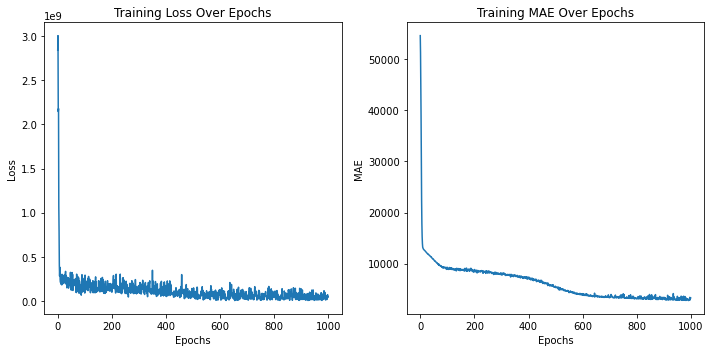

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x=range(num_epochs), y=loss_history, ax=ax[0])
ax[0].set_title('Training Loss Over Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
sns.lineplot(x=range(num_epochs), y=loss_history_mae, ax=ax[1])
ax[1].set_title('Training MAE Over Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE')
fig.tight_layout()
plt.show()

In [95]:
best_loss, best_parameters

(5108898.5,
 [tensor([[-1.5311e-01,  1.3795e-01, -3.7548e-04,  ..., -1.4413e-02,
           -4.6494e-02,  5.9654e-03],
          [ 2.2787e-01, -3.6755e-01,  1.6348e+01,  ...,  2.0477e+01,
            2.2295e+01, -5.8098e+00],
          [ 1.3769e-02, -1.7538e-02,  1.6661e+01,  ...,  2.1418e+01,
            2.3121e+01, -6.0593e+00],
          ...,
          [-6.3616e-02,  2.2606e-01,  1.8409e-01,  ...,  6.8507e-02,
           -9.6002e-02, -6.6417e-03],
          [ 1.6896e-01,  5.0523e-02,  1.6367e+01,  ...,  2.0623e+01,
            2.2376e+01, -6.2087e+00],
          [-5.9722e-02, -2.3300e-01, -1.6635e-01,  ..., -9.4198e-02,
            2.2164e-01,  3.9399e-03]], device='cuda:0'),
  tensor([-0.2214,  0.1468,  0.1588, -0.2448,  0.1747,  0.1565, -0.1423, -0.2411,
          -0.0650,  0.0929, -0.0515,  0.2132,  0.1017, -0.1608,  0.1458,  0.2517,
          -0.1103,  0.1343, -0.1257,  0.0238,  0.0413,  0.0680,  0.0322, -0.0165,
          -0.0060, -0.1217, -0.0871, -0.2118, -0.3038,  0.0625, -0

In [96]:
model.load_state_dict({param_name: param for param_name, param in zip(model.state_dict().keys(), best_parameters)})

# Set the model to evaluation mode
model.eval()

# new_input = torch.FloatTensor([[3, 132.0, 80.0, 40.0, 102.0, 36.2, 0.442, 42]])  # Replace '...' with your actual input values
new_input = torch.FloatTensor(X_test.to_numpy()).to(device)
y_test_tensor = torch.FloatTensor(y_test.to_numpy()).to(device)

# Forward pass to get the prediction
with torch.no_grad():
    y_pred = model(new_input)

# Calculate Mean Squared Error
mse = nn.MSELoss()(y_pred.squeeze(), y_test_tensor)
print(f'Mean Squared Error on Test Data: {mse.item()}')
mae = nn.L1Loss()(y_pred.squeeze(), y_test_tensor)
# mae = nn.L1Loss(y_pred, y_test_tensor.unsqueeze(dim=1))
print(f'Mean Absolute Error: {mae:.2f}')



Mean Squared Error on Test Data: 76035024.0
Mean Absolute Error: 4032.01
